In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from keras.datasets import mnist

2025-02-25 17:31:05.525372: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 17:31:05.532510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740504665.544459      72 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740504665.547982      72 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 17:31:05.560849: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appro

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

In [152]:
train_dl = torch.utils.data.DataLoader(x_train,batch_size=60,shuffle=True)
val_dl = torch.utils.data.DataLoader(x_test,batch_size=60,shuffle=True)

In [153]:
# Defining Autoencoder model
class VAE_EXP(nn.Module):
    def __init__(self):
        super(VAE_EXP, self).__init__()
        
        #self.raw_beta = nn.Parameter(data=torch.Tensor(1), requires_grad=True)
        
        self.linear_encoder = nn.Sequential(
               nn.Linear(input_size, 128),
               nn.ReLU(),
               nn.Linear(128, 32),
               nn.ReLU(),
               nn.Linear(32, encoding_dim),
               nn.GELU()
           )
        
        self.encoder = nn.Sequential(
               nn.Conv2d(1,32,3,padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2,2),
               nn.Conv2d(32,16,3,padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2,2),
               nn.Conv2d(16,8,3,padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2,2),
           )
        self.decoder = nn.Sequential(
           nn.ConvTranspose2d(8,8,3,stride=2),
           nn.ReLU(),
           nn.ConvTranspose2d(8,16,2,stride=2),
           nn.ReLU(),
           nn.ConvTranspose2d(16,32,2,stride=2),
           nn.ReLU(),
           nn.Conv2d(32,1,3,padding=1),
           nn.Sigmoid(),
       )
        
        self.fc_mu = nn.Linear(8*9, latent_dim)
        self.fc_var = nn.Linear(8*9, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim, 8*9)
        
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def forward(self, x):
        x_conv_in = torch.tensor(x).unsqueeze(1)
        x_lin_in = x.reshape(len(x), np.prod(x.shape[1:]))
        
        conv_encoded = self.encoder(x_conv_in)
        linear_encoded = self.linear_encoder(x_lin_in)
        
        conv_encoded_flatten = torch.flatten(conv_encoded, start_dim=1)
        
        #print(conv_encoded_flatten.shape, "===========", linear_encoded.shape)
        
        result = conv_encoded_flatten + linear_encoded
        
        #print(result[0],"*****",conv_encoded_flatten[0],"++++",linear_encoded[0])
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        
        z = self.reparameterize(mu, log_var)
        
        decoded = self.decoder_input(z)
        decoded = decoded.view(-1,8,3,3)
        x_ = self.decoder(decoded)
        return  [x_, x, mu, log_var]

In [154]:
def loss_function(recons, input_, mu, log_var):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """

        kld_weight = 0.00025 #kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input_)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return loss

In [155]:
x_train.shape

(60000, 28, 28)

In [156]:
input_size = np.prod(x_train.shape[1:])
latent_dim = 128
encoding_dim = 72

In [157]:
# Setting random seed for reproducibility
torch.manual_seed(30)
model = VAE_EXP()

In [158]:
model = model.to("cuda")

In [159]:
num_epochs = 100
criterion = loss_function
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.002, steps_per_epoch=len(train_dl),epochs=num_epochs)

In [160]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss < (self.min_validation_loss + self.min_delta):
            print("*********************")
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [161]:
# Training the autoencoder
early_stopper = EarlyStopper(patience=5, min_delta=0.0001)
for epoch in range(num_epochs):
    model.train()
    trl = 0
    for bat in train_dl:
        train_data = bat.to("cuda")
        # Forward pass
        recons, input_, mu, log_var = model(train_data)
        input_ = input_.unsqueeze(1)
        loss = criterion(recons, input_, mu, log_var)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        sched.step()
        trl += loss.item()
        
    model.eval()
    vl = 0
    with torch.no_grad():
        for bat_val in val_dl:
            val_data = bat_val.to("cuda")
            recons, input_, mu, log_var = model(val_data)
            input_ = input_.unsqueeze(1)
            val_loss = criterion(recons, input_, mu, log_var)
            vl += val_loss.item()
    if early_stopper.early_stop(round(vl/len(val_dl),4)):
        break
    # Loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {trl/len(train_dl):.4f}, Val_Loss: {vl/len(val_dl):.4f}')

/tmp/ipykernel_72/30680453.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_conv_in = torch.tensor(x).unsqueeze(1)


Epoch [1/100], Loss: 0.1165, Val_Loss: 0.0714
Epoch [2/100], Loss: 0.0656, Val_Loss: 0.0621
Epoch [3/100], Loss: 0.0586, Val_Loss: 0.0555
Epoch [4/100], Loss: 0.0513, Val_Loss: 0.0471
Epoch [5/100], Loss: 0.0449, Val_Loss: 0.0425
Epoch [6/100], Loss: 0.0411, Val_Loss: 0.0392
Epoch [7/100], Loss: 0.0375, Val_Loss: 0.0352
Epoch [8/100], Loss: 0.0339, Val_Loss: 0.0318
Epoch [9/100], Loss: 0.0305, Val_Loss: 0.0285
Epoch [10/100], Loss: 0.0279, Val_Loss: 0.0266
Epoch [11/100], Loss: 0.0263, Val_Loss: 0.0252
Epoch [12/100], Loss: 0.0252, Val_Loss: 0.0243
Epoch [13/100], Loss: 0.0244, Val_Loss: 0.0237
Epoch [14/100], Loss: 0.0238, Val_Loss: 0.0233
Epoch [15/100], Loss: 0.0235, Val_Loss: 0.0232
Epoch [16/100], Loss: 0.0231, Val_Loss: 0.0228
Epoch [17/100], Loss: 0.0228, Val_Loss: 0.0224
Epoch [18/100], Loss: 0.0226, Val_Loss: 0.0220
Epoch [19/100], Loss: 0.0223, Val_Loss: 0.0218
Epoch [20/100], Loss: 0.0221, Val_Loss: 0.0217
Epoch [21/100], Loss: 0.0219, Val_Loss: 0.0213
*********************


In [90]:
# model.raw_beta

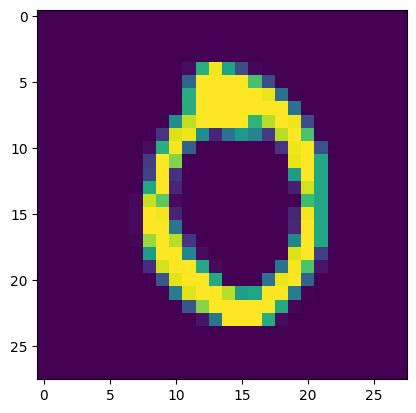

In [162]:
i = 26
plt.imshow(bat_val[i].reshape(28,28))

/tmp/ipykernel_72/30680453.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_conv_in = torch.tensor(x).unsqueeze(1)


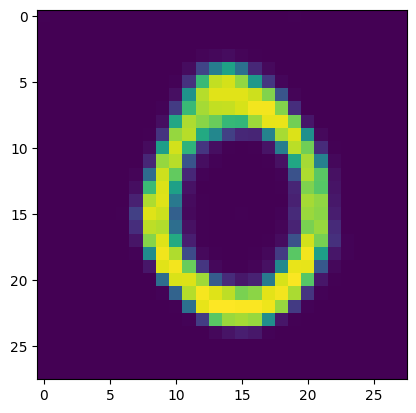

In [163]:
output = model(bat_val[i].unsqueeze(0).to("cuda"))[0].detach().cpu()
plt.imshow(output[0].reshape(28,28))